<a href="https://colab.research.google.com/github/abhinf104/graph_neural_network/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔬 Why Graphs for Materials?

In materials science, we want to understand how atoms arrange themselves and how those arrangements give rise to properties like:

electrical conductivity,

magnetism,

chemical stability.

Traditional machine learning approaches flatten atomic data into long vectors, which lose the spatial relationships between atoms.
By contrast, Graph Neural Networks (GNNs) naturally preserve geometry and composition:

atoms → nodes,

bonds or neighbor relationships → edges.

This makes them powerful tools for predicting material properties.

Graph Neural Networks let us model materials directly from atomic structures, without hand-crafted features. They:

respect the geometry and chemistry of materials,

enable property prediction from first principles,

but require careful design to avoid oversmoothing.

### Crystal → Graph

Input: a CIF file (e.g., BiFeO3.cif).

Process:

Use pymatgen and ASE to parse structure.

Each atom → node (with attributes like element type).

Neighbors within 4 Å → edges (with distance as a possible feature).

Output: a graph drawn with NetworkX, showing Bi (orange), Fe (red), O (blue).
→ This graph is the same format a GNN (like CGCNN) will use for learning.

In [8]:
# --- Install (run once per environment) ---
# If you're in Colab/Jupyter, uncomment:
!pip install --upgrade ase pymatgen networkx matplotlib numpy torch matminer mp-api

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from pymatgen.io.cif import CifParser
from pymatgen.io.ase import AseAtomsAdaptor
from ase.neighborlist import neighbor_list

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.4/264.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.7/123.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.9/223.9 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

🔎 What is an ASE object?

ASE stands for the Atomic Simulation Environment — it’s a Python library widely used in materials science and computational chemistry.

The ASE object you saw (atoms = AseAtomsAdaptor.get_atoms(structure)) is an instance of the class ase.Atoms.

🧱 The ase.Atoms object

This is the core data structure of ASE. It represents a collection of atoms and contains:

Atomic positions in Cartesian coordinates (x, y, z).

Chemical species (H, O, Fe, etc.).

Cell information (the simulation box or crystal lattice).

Periodic boundary conditions (PBCs).

Optional: atomic charges, magnetic moments, velocities, etc.

Think of it as a container that fully describes a material structure in 3D space.


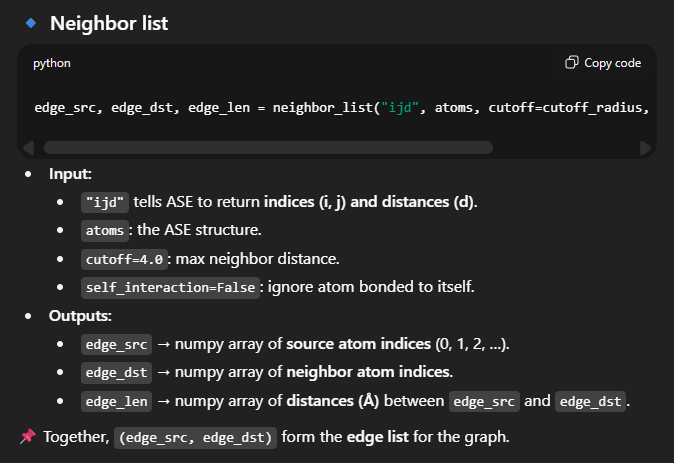

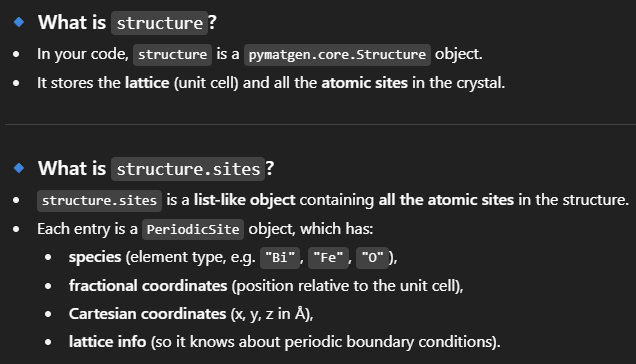

[PeriodicSite: BI1 (Bi) (0.0, 0.0, 0.0) [0.0, 0.0, 0.0], PeriodicSite: BI1 (Bi) (-5.582, -3.223, -2.313) [0.5, 0.5, 0.5], PeriodicSite: FE2 (Fe) (-2.791, -1.611, -1.558) [0.2211, 0.2211, 0.3367], PeriodicSite: FE2 (Fe) (-8.373, -4.834, -3.871) [0.7211, 0.7211, 0.8367], PeriodicSite: O3 (O) (-5.932, -4.75, -0.6614) [0.9349, 0.5238, 0.143], PeriodicSite: O3 (O) (-4.084, -2.763, -0.6614) [0.5238, 0.3983, 0.143], PeriodicSite: O3 (O) (-6.729, -2.156, -0.6614) [0.3983, 0.9349, 0.143], PeriodicSite: O3 (O) (-8.023, -3.138, -2.974) [0.4349, 0.8983, 0.643], PeriodicSite: O3 (O) (-4.435, -5.379, -2.974) [0.8983, 0.02383, 0.643], PeriodicSite: O3 (O) (-4.289, -1.151, -2.974) [0.02383, 0.4349, 0.643]]
Bi
[0. 0. 0.]
[0. 0. 0.]


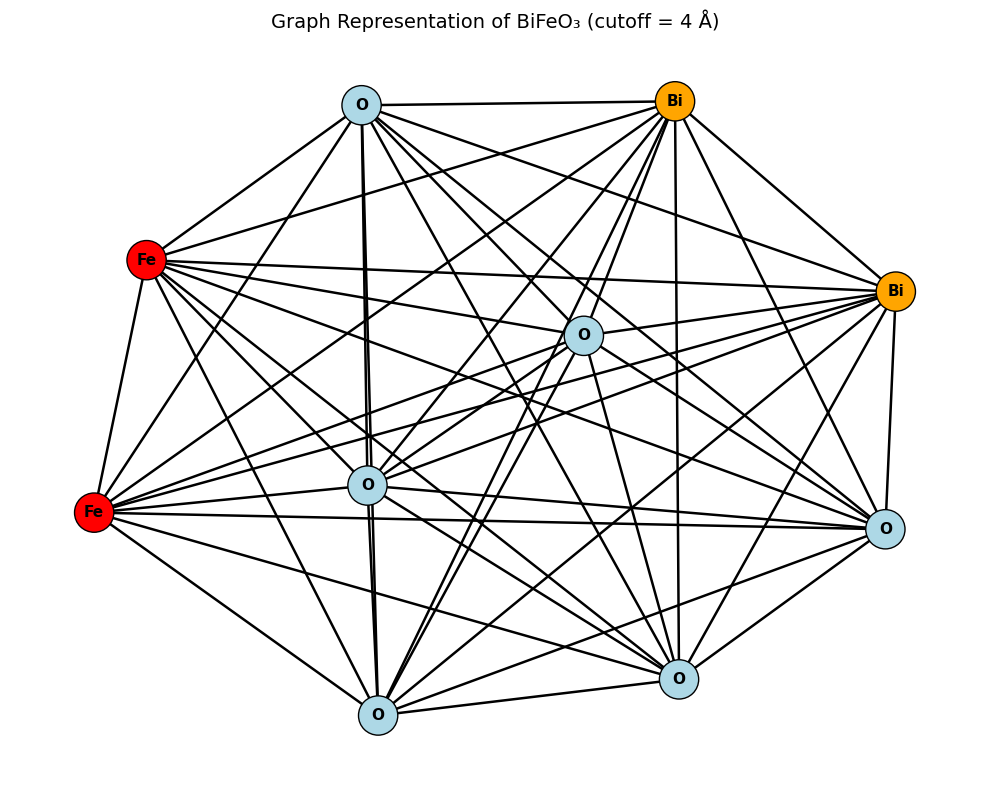

In [3]:
# ---------- Helper: safe conversion preserving ASE PBC ----------
##In crystalline materials, atoms repeat periodically in 3D space.
##CIF files store this lattice periodicity.
##When converting pymatgen.Structure → ase.Atoms, sometimes ASE does not automatically set the PBCs correctly, or you may want to force custom PBC settings (like periodic only in x and y, not z).
def pmg_to_ase_with_pbc(structure, force_pbc=None):
    """
    Convert pymatgen Structure -> ASE Atoms.
    Optionally force a specific per-axis PBC on the ASE Atoms.
    """
    atoms = AseAtomsAdaptor.get_atoms(structure)
    if force_pbc is not None:
        atoms.set_pbc(force_pbc)
    return atoms


# ---------- Load structure (modern API) ----------
parser = CifParser("/content/BiFeO3.cif")
# New method (replaces deprecated get_structures)
structure = parser.parse_structures(primitive=True)[0]
# print("Structure loaded:", structure.composition.reduced_formula)

# ---------- Convert to ASE and (optionally) enforce PBC ----------
# For BiFeO3 (a bulk crystal), full periodicity is expected.
# If you *want* partial PBC for a special test, set force_pbc=(True, True, False).
atoms = pmg_to_ase_with_pbc(structure, force_pbc=None)
# print("ASE PBC observed:", atoms.get_pbc())
# print(atoms.get_chemical_formula(),atoms.get_cell())

# # ---------- Neighbor list ----------
cutoff_radius = 4.0  # Å
edge_src, edge_dst, edge_len = neighbor_list("ijd", atoms, cutoff=cutoff_radius, self_interaction=False)
#which atom index is connected to which neighbor, and at what distance.

# Print the first 20 neighbor pairs
# for s, d, l in zip(edge_src[:20], edge_dst[:20], edge_len[:20]):
#     print(f"Atom {s} --> Atom {d}, distance = {l:.2f} Å")


# # ---------- Build graph ----------
color_map = {"Bi": "orange", "Fe": "red", "O": "lightblue"}
G = nx.Graph()

print(structure.sites)
site0 = structure.sites[0]
print(site0.species_string)   # "Bi"
print(site0.frac_coords)      # fractional coordinates (0, 0, 0)
print(site0.coords)           # cartesian coordinates (x,y,z in Å)

for i, site in enumerate(structure.sites):
    G.add_node(i, element=site.species_string)

for i, j, d in zip(edge_src, edge_dst, edge_len):
    G.add_edge(int(i), int(j), length=float(d))

labels = {i: G.nodes[i]["element"] for i in G.nodes}
colors = [color_map[G.nodes[i]["element"]] for i in G.nodes]

# # ---------- Plot ----------
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 8), facecolor="white")
nx.draw_networkx_nodes(G, pos, node_color=colors, edgecolors="black", node_size=800)
nx.draw_networkx_edges(G, pos, width=1.8)
nx.draw_networkx_labels(G, pos, labels, font_size=11, font_weight="bold")
plt.title("Graph Representation of BiFeO₃ (cutoff = 4 Å)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


## How to program and code a GNN?

In [ ]:
# !pip install matminer

In [1]:
# Here we will take some libraries to construct the neural-networks using torch.
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

# Here are some diverse modules and functions necessary.
import random
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# ASE and pymatgen modules
from ase import Atoms
from ase.neighborlist import neighbor_list
from pymatgen.io.ase import AseAtomsAdaptor

# matminer
# Be mindful that the MPDataRetrieval was here only tested for the old MP database!

from matminer.data_retrieval.retrieve_MP import MPDataRetrieval

# Used for storing the datas. (Uses the method of Alex Ganose [a.ganose@imperial.ac.uk] for handling the datas)
import functools
from dataclasses import dataclass
from torch.utils.data import Dataset

In [2]:
# To ensure a reproducible results, we put the same random seed.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [11]:
import os
import pandas as pd
from mp_api.client import MPRester

from google.colab import userdata
mp_api = userdata.get('MP_API')

API_KEY = mp_api

fields = ["material_id", "formula_pretty", "formation_energy_per_atom", "structure"]

with MPRester(API_KEY) as mpr:
    # Tip: fetching EVERYTHING is huge. Start with a filter like is_stable=True or an elements subset.
    docs = mpr.materials.summary.search(
        fields=fields,
        is_stable=True,           # <-- optional but strongly recommended to limit size
        elements=["Li","O"],    # <-- example filter (any subset you want)
        # chemical_system="Na-Cl" # <-- another way to filter
    )

# Convert to a DataFrame compatible with the rest of your pipeline
df = pd.DataFrame(
    {
        "material_id": [d.material_id for d in docs],
        "pretty_formula": [d.formula_pretty for d in docs],
        "formation_energy_per_atom": [d.formation_energy_per_atom for d in docs],
        "structure": [d.structure for d in docs],
    }
).set_index("material_id")

df.head()


Retrieving SummaryDoc documents:   0%|          | 0/701 [00:00<?, ?it/s]

,pretty_formula,formation_energy_per_atom,structure
material_id,,,
mp-1235059,LiO8,-0.427069,"[[4.78380667 3.60223102 6.81002159] Li, [5.485..."
mp-2348641,LiNiO2,-1.497991,"[[ 2.50898347 -4.32089307 0.01661233] Li, [ 1..."
mp-27281,LiH3O2,-1.535539,"[[1.13236098 2.70115203 4.50847782] Li, [-0.66..."
mp-2760269,LiNi3O4,-1.387793,"[[ 2.52287687 -2.26455078 3.69574924] Li, [ 2..."
mp-754656,LiMnO2,-2.159870,"[[-1.1829655 1.40493724 2.40356054] Li, [0...."


In [18]:
for i, struct in enumerate(df["structure"].head(1)):
    print(f"\nEntry {i} ({df.index[i]} - {df['pretty_formula'].iloc[i]}):")
    print(struct)

s = df["structure"].iloc[0]

print(type(s))              # should be <class 'pymatgen.core.structure.Structure'>
print(s)                    # human-readable lattice + sites summary
print(s.composition)        # formula with element counts
print(s.lattice)            # lattice vectors and lengths/angles
print(s[0])                 # first site (atom) with coordinates and species
print(s.sites[:3])          # first 3 sites

# convert to ASE Atoms if needed
from pymatgen.io.ase import AseAtomsAdaptor
atoms = AseAtomsAdaptor.get_atoms(s)
print(atoms)                # ASE Atoms summary
print(atoms.get_positions())  # Cartesian coordinates



Entry 0 (mp-1235059 - LiO8):
Full Formula (Li1 O8)
Reduced Formula: LiO8
abc   :   5.249755   5.413199   5.412214
angles:  66.067935  55.049841  55.053804
pbc   :       True       True       True
Sites (9)
  #  SP           a         b         c    magmom
---  ----  --------  --------  --------  --------
  0  Li    0.492367  0.782749  0.782734    -0
  1  O     0.855917  0.3349    0.772908    -0.533
  2  O     0.185075  0.212971  0.633871    -0.541
  3  O     0.185202  0.633889  0.212853    -0.54
  4  O     0.85587   0.773034  0.334847    -0.532
  5  O     0.855046  0.275612  0.27576      0.775
  6  O     0.184786  0.699556  0.699619     0.736
  7  O     0.175463  0.150416  0.150429     0.731
  8  O     0.863051  0.827348  0.827452     0.74
<class 'pymatgen.core.structure.Structure'>
Full Formula (Li1 O8)
Reduced Formula: LiO8
abc   :   5.249755   5.413199   5.412214
angles:  66.067935  55.049841  55.053804
pbc   :       True       True       True
Sites (9)
  #  SP           a         

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-556867357.py:3: SyntaxWarning: invalid escape sequence '\m'
  ax.set(xlabel="$\mathrm{E}_\mathrm{f}/\mathrm{atom}$", ylabel="Number of examples")


[Text(0.5, 0, '$\\mathrm{E}_\\mathrm{f}/\\mathrm{atom}$'),
 Text(0, 0.5, 'Number of examples')]

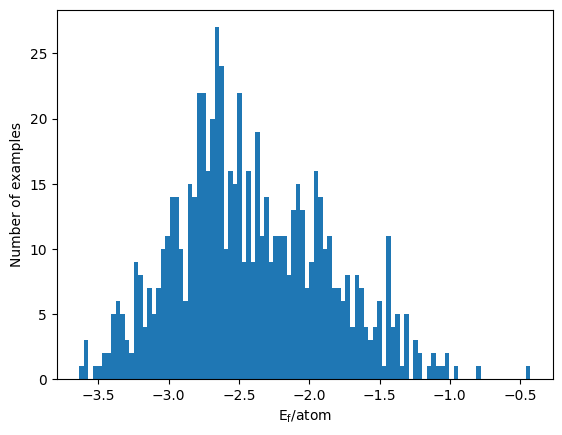

In [14]:
fig, ax = plt.subplots()
ax.hist(df["formation_energy_per_atom"], bins=100)
ax.set(xlabel="$\mathrm{E}_\mathrm{f}/\mathrm{atom}$", ylabel="Number of examples")

In [13]:
def one_hot_encode_z(atomic_number:int):
    """We return a onehot encoding of the periodic table of elements, inputting the Z number gives the good onehot encoding for the atom in question."""
    vector = np.zeros(118)
    vector[atomic_number-1] = 1
    return vector

In [21]:
node_features = torch.tensor(np.array([one_hot_encode_z(site.species.elements[0].Z) for site in df["structure"].iloc[0]]))
# Here our atom is "Li" with Z=3, so we look at the 2th place to find it back.
print(node_features[0][2])
print(node_features[0])

tensor(1., dtype=torch.float64)
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)


Why edges need a distance weight

If you just aggregate neighbor messages equally, a far atom and a near atom affect the center the same. That’s physically odd—nearby atoms should matter more. A simple fix is to convert distance
𝑑
d to a weight
𝑤
w that down-weights far neighbors.

The most bare-bones version you used:

𝑤
(
𝑑
)

=

max
⁡
 ⁣
(
0
,

1
−
𝑑
𝑅
)
,
w(d)=max(0,1−
R
d
	​

),

where
𝑅
R is the cutoff (so
0
≤
𝑤
≤
1
0≤w≤1; neighbors at the cutoff contribute ~0).
This makes closer neighbors (small
𝑑
d) contribute more to the message passing.

In [23]:
cutoff_radius = 4 # Angstrom
atoms = AseAtomsAdaptor.get_atoms(df["structure"].iloc[0])
edge_src, edge_dst, edge_len = neighbor_list(
                "ijd", atoms, cutoff=cutoff_radius, self_interaction=False
            )
# Cell parameter of atoms
atoms.cell

Cell([[4.72630922, 0.275826299999999, 2.26844515], [2.25109754, 4.52658601, 1.93527925], [0.88750719, -0.09806545, 5.33804978]])

In [24]:
## Classes of datas (these classes show how the data will be stored).
@dataclass
class Data:
    """
    Class to contain graph attributes.

    N and M are the number of nodes and edges in the graph, respectively.

    Parameters
    ----------
    x : Tensor
        The node features as a (N, n_node_feats) Tensor.
    edge_len : Tensor
        The edge length as a (M, ) Tensor.
    edge_index:
        [0] The index of the central node for each edge.
        [1] The index of the destination node for each edge.
    y : Tensor
        The target property to learn.
    atoms : Atoms
        An ase atoms object.
    """

    x: torch.Tensor
    y: torch.Tensor
    edge_len: torch.Tensor
    edge_index: torch.LongTensor
    atoms: Atoms

@dataclass
class Batch:
    """
    Class to contain batched graph attributes.

    N and M are the number of nodes and edges across all batched graphs,
    respectively.

    G is the number of graphs in the batch.

    Parameters
    ----------
    node_feat : Tensor
        The node features as a (N, n_node_feats) Tensor.
    edge_len : Tensor
        The edge length as a (M, ) Tensor
    edge_src : LongTensor
        The index of the central node for each edge.
    edge_dst : LongTensor
        The index of the destination node for each edge.
    edge_index:
        [0] The index of the central node for each edge.
        [1] The index of the destination node for each edge.
    y : Tensor
        The target property to learn, as a (G, 1) Tensor.
    batch : LongTensor
        The graph to which each node belongs, as a (N, ) Tensor.
    """

    x: torch.Tensor
    y: torch.Tensor
    edge_len: torch.Tensor
    edge_src: torch.LongTensor
    edge_dst: torch.LongTensor
    edge_index: torch.LongTensor
    batch: torch.LongTensor

    def to(self, device, non_blocking=False):
        for k, v in self.__dict__.items():
            self.__dict__[k] = v.to(device=device, non_blocking=non_blocking)

# First we take the data and store it inside a MaterialsDataSet (function created by Alex Ganose [a.ganose@imperial.ac.uk], adapted for this application.)

class MaterialsDataset_MP(Dataset):
    def __init__(self, df:pd.DataFrame, target_column:str, cutoff:float=4):
        """
        A dataset of materials properties extracted from Material Project.

        Parameters
        ----------
        df : pd.DataFrame
            DataFrame from Material Project.
        target_column : str
            Column of df used as the target.
        cutoff : float
            The cutoff radius for searching for neighbors.
        """

        self.dataframe      = df
        self.data           = {i: {} for i in range(df.shape[0])}
        self.target_column  = target_column
        self.cutoff         = cutoff
        #
        for entry in range(self.dataframe.shape[0]):
            atoms = AseAtomsAdaptor.get_atoms(self.dataframe["structure"].iloc[entry])
            edge_src, edge_dst, edge_len = neighbor_list(
                "ijd", atoms, cutoff=self.cutoff, self_interaction=False
            )
            self.data[entry].update(
                {
                    "atoms": atoms,
                    "edge_src": edge_src,
                    "edge_dst": edge_dst,
                    "edge_len": edge_len,
                }
            )

    def __len__(self):
        return len(self.data)

    @functools.lru_cache(maxsize=None)
    def __getitem__(self, idx):
        entry = self.data[idx]

        # one hot encode element type
        node_feat = torch.Tensor([one_hot_encode_z(el) for el in entry["atoms"].get_atomic_numbers()])

        # Setup edge_distance to weight the edges.
        edge_distance=torch.tensor(1.0 - np.array(entry["edge_len"])/self.cutoff,dtype=torch.float32) #

        return Data(
            x=torch.Tensor(node_feat),
            y=torch.Tensor([ self.dataframe[self.target_column].iloc[idx] ]),
            edge_len=torch.Tensor(edge_distance),
            edge_index=torch.Tensor(np.array([entry["edge_src"],entry["edge_dst"]])),
            atoms=entry["atoms"],
        )


# Then we use the collate_fn for creating the batches (function created by Alex Ganose [a.ganose@imperial.ac.uk], adapted for this application.)
def collate_fn(dataset):
    """
    Collate a list of Data objects and return a Batch.

    Parameters
    ----------

    dataset : MaterialsDataset_MP
        The dataset to batch.

    Returns
    -------
    Batch
        A batched dataset.
    """
    batch = Batch([], [], [], [], [], [], [])
    base_idx = 0
    for i, data in enumerate(dataset):
        batch.x.append(data.x)
        batch.y.append(data.y)
        batch.edge_len.append(data.edge_len)
        #
        batch.edge_index.append(data.edge_index + base_idx)
        batch.edge_src.append(data.edge_index[0] + base_idx)
        batch.edge_dst.append(data.edge_index[1] + base_idx)
        batch.batch.extend([i] * len(data.x))
        base_idx += len(data.x)
    return Batch(
        x=torch.cat(batch.x),
        y=torch.stack(batch.y),
        edge_len=torch.cat(batch.edge_len),
        edge_src=torch.cat(batch.edge_src).to(torch.long),
        edge_dst=torch.cat(batch.edge_dst).to(torch.long),
        edge_index=torch.LongTensor(np.array([torch.cat(batch.edge_src),torch.cat(batch.edge_dst)],dtype=np.int64)),
        batch=torch.LongTensor(batch.batch),
    )

In [41]:
cutoff_radius = 4.0
sample_size   = 700

sampled_df = df.sample(n=sample_size, random_state=SEED)

dataset = MaterialsDataset_MP(
    sampled_df,
    "formation_energy_per_atom",
    cutoff=cutoff_radius,  # cutoff radius for finding neighbours
)

In [42]:
BATCH_SIZE       = 32
sampling_factors = [0.8, 0.1, 0.1]

train_set, valid_set, test_set = random_split(dataset, sampling_factors)

print(f'Number of training examples: {len(train_set)}')
print(f'Number of validation examples: {len(valid_set)}')
print(f'Number of testing examples: {len(test_set)}')

train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True,
)

val_loader = DataLoader(
    valid_set, batch_size=BATCH_SIZE, collate_fn=collate_fn,
)

test_loader = DataLoader(
    test_set, batch_size=BATCH_SIZE, collate_fn=collate_fn,
)

## Correct all the dtypes.
for batch in train_loader:
    batch.edge_index = batch.edge_index.to(torch.int64)
    batch.edge_src   = batch.edge_src.to(torch.int64)
    batch.edge_dst   = batch.edge_dst.to(torch.int64)
    batch.edge_len   = batch.edge_len.to(torch.float32)

for batch in val_loader:
    batch.edge_index = batch.edge_index.to(torch.int64)
    batch.edge_src   = batch.edge_src.to(torch.int64)
    batch.edge_dst   = batch.edge_dst.to(torch.int64)
    batch.edge_len   = batch.edge_len.to(torch.float32)

for batch in test_loader:
    batch.edge_index = batch.edge_index.to(torch.int64)
    batch.edge_src   = batch.edge_src.to(torch.int64)
    batch.edge_dst   = batch.edge_dst.to(torch.int64)
    batch.edge_len   = batch.edge_len.to(torch.float32)

Number of training examples: 560
Number of validation examples: 70
Number of testing examples: 70


In [43]:
!pip install torch_geometric utils

In [44]:
from torch_geometric.nn import GraphConv, global_mean_pool

class GNN(nn.Module):
    def __init__(self, node_feat_dim, node_hidden_dim=64, num_graph_conv_layers=3, fc_feat_dim=128):
        super().__init__()
        self.embedding = nn.Linear(node_feat_dim, node_hidden_dim)
        self.convs = nn.ModuleList([
            GraphConv(node_hidden_dim, node_hidden_dim, aggr="mean")
            for _ in range(num_graph_conv_layers)
        ])
        self.conv_to_fc = nn.Sequential(
            nn.Linear(node_hidden_dim, fc_feat_dim), nn.Softplus()
        )
        self.fc_out = nn.Linear(fc_feat_dim, 1)

    def forward(self, batch):
        x = self.embedding(batch.x)
        for conv in self.convs:
            x = conv(x, batch.edge_index, edge_weight=batch.edge_len)

        # graph-level pooling (mean over all nodes belonging to each graph in batch)
        crys_feat = global_mean_pool(x, batch.batch)

        crys_feat = self.conv_to_fc(crys_feat)
        return self.fc_out(crys_feat)


In [45]:
def train(dataloader, model, optimizer, criterion):
    epoch_loss = 0
    epoch_mae = 0

    model.train()

    for i, batch in enumerate(dataloader):
        # move the data onto the GPU if available
        # compute output
        y_pred = model(batch)
        loss = criterion(y_pred, batch.y)
        mae = nn.L1Loss()(y_pred, batch.y)

        # compute gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update metrics
        epoch_loss += loss.item()
        epoch_mae += mae.item()

    return epoch_loss / len(dataloader), epoch_mae / len(dataloader)

def evaluate(dataloader, model, criterion):
    epoch_loss = 0
    epoch_mae = 0

    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(dataloader):

            # compute output
            y_pred = model(batch)
            loss = criterion(y_pred, batch.y)
            mae = nn.L1Loss()(y_pred, batch.y)

            # update metrics
            epoch_loss += loss.item()
            epoch_mae += mae.item()

    return epoch_loss / len(dataloader), epoch_mae / len(dataloader)

In [46]:
# Instantiate the model
hidden_channels         = 64
num_graph_conv_layers   = 3
fc_feat_dim             = 128
max_epoch               = 60


in_node_features = dataset[0].x.size()[1]
model = GNN(in_node_features, hidden_channels,num_graph_conv_layers=num_graph_conv_layers,fc_feat_dim=fc_feat_dim)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # We use a basic Adam optimizer.
criterion = torch.nn.MSELoss()  # Use CrossEntropyLoss for classification tasks

start_time = time.time()
save_losses_train = []
save_losses_valid = []
save_mae_train = []
save_mae_valid = []
# Using the DataLoaders for training and validation
for epoch in range(0,max_epoch):
    train_loss,train_mae = train(train_loader,model,optimizer,criterion)
    val_loss,valid_mae = evaluate(val_loader,model,criterion)
    # Save validation and losses.
    save_losses_train.append(train_loss)
    save_losses_valid.append(val_loss)
    save_mae_train.append(train_mae)
    save_mae_valid.append(valid_mae)
    #
    epoch_time = time.time() - start_time
    print(f'Epoch: {epoch+1:02} | Train MAE: {train_mae:8.4f} | Valid MAE: {valid_mae:8.4f}'
         f' |   Elapsed time: {time.strftime("%M min %S s", time.gmtime(epoch_time))}')
# Test the model
test_loss,test_mae = evaluate(test_loader,model,criterion)
print(f'Test Loss: {test_loss:.4f} | Test MAE: {test_mae:.4f}')

Epoch: 01 | Train MAE:   0.9734 | Valid MAE:   0.7101 |   Elapsed time: 00 min 00 s
Epoch: 02 | Train MAE:   0.4609 | Valid MAE:   0.5389 |   Elapsed time: 00 min 01 s
Epoch: 03 | Train MAE:   0.4413 | Valid MAE:   0.5366 |   Elapsed time: 00 min 02 s
Epoch: 04 | Train MAE:   0.4319 | Valid MAE:   0.5278 |   Elapsed time: 00 min 03 s
Epoch: 05 | Train MAE:   0.4227 | Valid MAE:   0.5187 |   Elapsed time: 00 min 03 s
Epoch: 06 | Train MAE:   0.4060 | Valid MAE:   0.4941 |   Elapsed time: 00 min 05 s
Epoch: 07 | Train MAE:   0.3281 | Valid MAE:   0.3627 |   Elapsed time: 00 min 05 s
Epoch: 08 | Train MAE:   0.2292 | Valid MAE:   0.2930 |   Elapsed time: 00 min 07 s
Epoch: 09 | Train MAE:   0.1840 | Valid MAE:   0.2615 |   Elapsed time: 00 min 08 s
Epoch: 10 | Train MAE:   0.1488 | Valid MAE:   0.2692 |   Elapsed time: 00 min 09 s
Epoch: 11 | Train MAE:   0.1321 | Valid MAE:   0.2541 |   Elapsed time: 00 min 10 s
Epoch: 12 | Train MAE:   0.1204 | Valid MAE:   0.2278 |   Elapsed time: 00 m

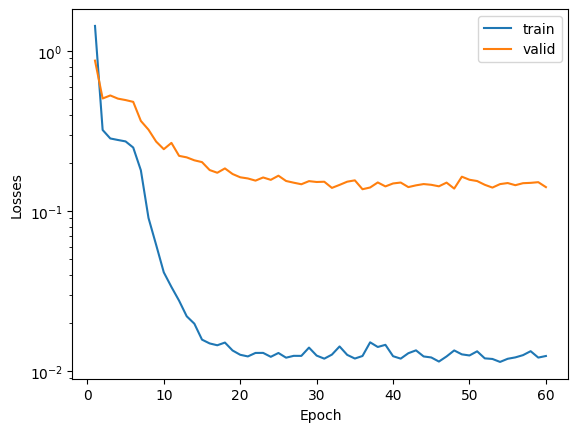

In [47]:
fig, ax = plt.subplots()
ax.plot(range(1,max_epoch+1), save_losses_train, label="train")
ax.plot(range(1,max_epoch+1), save_losses_valid, label="valid")
ax.set(xlabel="Epoch", ylabel="Losses")
ax.set_yscale("log")
plt.legend()

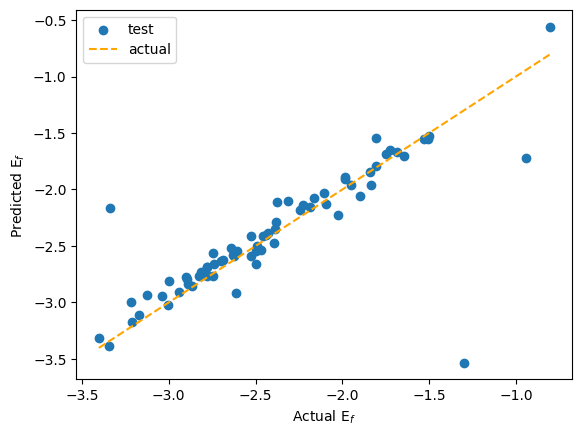

In [48]:
import matplotlib.pyplot as plt

actual = []
predicted = []

model.eval()
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        y_pred = model(batch)
        predicted.extend(y_pred.data.cpu().tolist())
        actual.extend(batch.y.tolist())
#
min_val, max_val = np.min(actual), np.max(actual)
#
fig, ax = plt.subplots()
ax.scatter(np.array(actual), np.array(predicted), label="test")
ax.plot([min_val, max_val], [min_val, max_val], color="orange", linestyle="--", label="actual")
ax.set(ylabel="Predicted E$_{f}$", xlabel="Actual E$_{f}$")
plt.legend()

In [2]:
from mace.calculators import mace_mp
from ase import build

calc = mace_mp()  # load pretrained model (default = medium-mpa-0)
atoms = build.molecule("H2O")
atoms.calc = calc

print("Energy (eV):", atoms.get_potential_energy())
print("Forces (eV/Å):", atoms.get_forces())


Using medium MPA-0 model as default MACE-MP model, to use previous (before 3.10) default model please specify 'medium' as model argument
Using Materials Project MACE for MACECalculator with /root/.cache/mace/macempa0mediummodel
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Using head default out of ['default']
Default dtype float32 does not match model dtype float64, converting models to float32.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Energy (eV): -13.785926818847656
Forces (eV/Å): [[ 0.          0.          0.10339409]
 [ 0.          0.07019126 -0.05169705]
 [ 0.         -0.07019126 -0.05169705]]


In [1]:
# !pip install git+https://github.com/ACEsuit/mace.git
from mace.calculators import mace_mp
from ase import build
from ase.md import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units

macemp = mace_mp() # return the default medium ASE calculator equivalent to mace_mp(model="medium") in MACE < 0.3.10 and mace_mp(model="medium-mpa-0") in MACE >= 0.3.10
#macemp = mace_mp(model="large") # return a larger model
#macemp = mace_mp(model="https://tinyurl.com/y7uhwpje") # downlaod the model at the given url
#macemp = mace_mp(dispersion=True) # return a model with D3 dispersion correction
atoms = build.bulk('NaCl', crystalstructure='rocksalt', a=5.64)
atoms.calc = macemp

# Initialize velocities.
T_init = 1300  # Initial temperature in K
MaxwellBoltzmannDistribution(atoms, T_init * units.kB)

# Set up the Langevin dynamics engine for NVT ensemble.
dyn = Langevin(atoms, 0.5 * units.fs, T_init * units.kB, 0.001)
n_steps = 200 # Number of steps to run
dyn.run(n_steps)

/usr/local/lib/python3.12/dist-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Using medium MPA-0 model as default MACE-MP model, to use previous (before 3.10) default model please specify 'medium' as model argument
Using Materials Project MACE for MACECalculator with /root/.cache/mace/macempa0mediummodel
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head default out of ['default']
Default dtype float32 does not match model dtype float64, converting models to float32.


/usr/local/lib/python3.12/dist-packages/ase/md/md.py:54: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


True

In [1]:
# Install if needed (uncomment if not already installed)
# !pip install mace-torch ase
# !pip install nglview

from mace.calculators import mace_mp
from ase import build, units
from ase.md import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.io import Trajectory, read
from ase.visualize import view

# 1. Build system and attach pretrained MACE calculator
atoms = build.bulk('NaCl', crystalstructure='rocksalt', a=5.64)
atoms.calc = mace_mp()   # default = "medium-mpa-0" model

# 2. Initialize velocities at high temperature (above NaCl melting point)
T_init = 1300  # Kelvin
MaxwellBoltzmannDistribution(atoms, T_init * units.kB)

# 3. Set up Langevin dynamics (NVT ensemble)
dyn = Langevin(atoms, 0.5 * units.fs, T_init * units.kB, friction=0.001)

# 4. Attach trajectory writer
traj = Trajectory("nacl_md.traj", "w", atoms)
dyn.attach(traj.write, interval=10)  # save every 10 steps

# 5. Run MD (short demo run)
dyn.run(200)

# 6. Reload trajectory and visualize
images = read("nacl_md.traj", ":")   # ":" loads all frames
view(images, viewer="ngl")           # NGL = browser widget, works in notebooks

/usr/local/lib/python3.12/dist-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Using medium MPA-0 model as default MACE-MP model, to use previous (before 3.10) default model please specify 'medium' as model argument
Using Materials Project MACE for MACECalculator with /root/.cache/mace/macempa0mediummodel
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head default out of ['default']
Default dtype float32 does not match model dtype float64, converting models to float32.


/usr/local/lib/python3.12/dist-packages/ase/md/md.py:54: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))
